# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In this note book, a classifier to recognize traffic sign was built based on Convolutional Neural Networks, which is a project of the Udacity Self-driving Cars Nanodegree program. A fraction of [the German Traffic Sign Recognition Benchmark dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) was used to train this model. The training and validation data in pickle format can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip).

Images in the pickle files are asymmetric data of 43 categories. Hence, image augmentation has been performed to overcome overfitting.

The final model includes three convolutional layers followed by three fully connected layers. Each layer was followed by a dropout layer to avoid overfitting. After every two convolutional layers, a maxpooling layer was added to reduce the dimensionality of images. The final validation accuracy of our model is 97%, and the test accuracy is 98%. Six test images has been downloaded from the internet for further testing, and the test accuracy on these images is 66.7%.

---
## Step 0: Load The Data

The pickle files of training, validation and testing data are provided by the Self-driving Cars Nanodegree program, which was downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). 6 images downloaded from the internet were used for testing.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/test.p'
testing_file = './traffic-signs-data/valid.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Images of the data have been resized to 32x32, and all of them are RGB color images. There are 34799 training images, 12630 validation validation images, and 4410 test images.

There are 43 categories of traffic signs in the data.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.utils import shuffle

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
classes = np.unique(np.hstack([y_train, y_valid]))
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 12630
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

43 images was shown below with one arbitrary image from each category of the training image. The traffic signs in the train image have been pruned such that they are ovarally in similar size and in the center of the images. However, the intensity significantly varies from images to images, and some images were not taken precisely in the front view and some were not exactly aligned perpenticular to the ground. 

The histogram of categories in the training data was plotted as well, which indicates that the dataset is asymmetric. Some categories have more than 1000 examples, while others have less than 200 examples.

It looks that data augmentation is required for this dataset to avoid overfitting of our ConvNet model, and the augmentation can be completed by applying transforms on the intensity, scale, orientation and perspective of the original images.

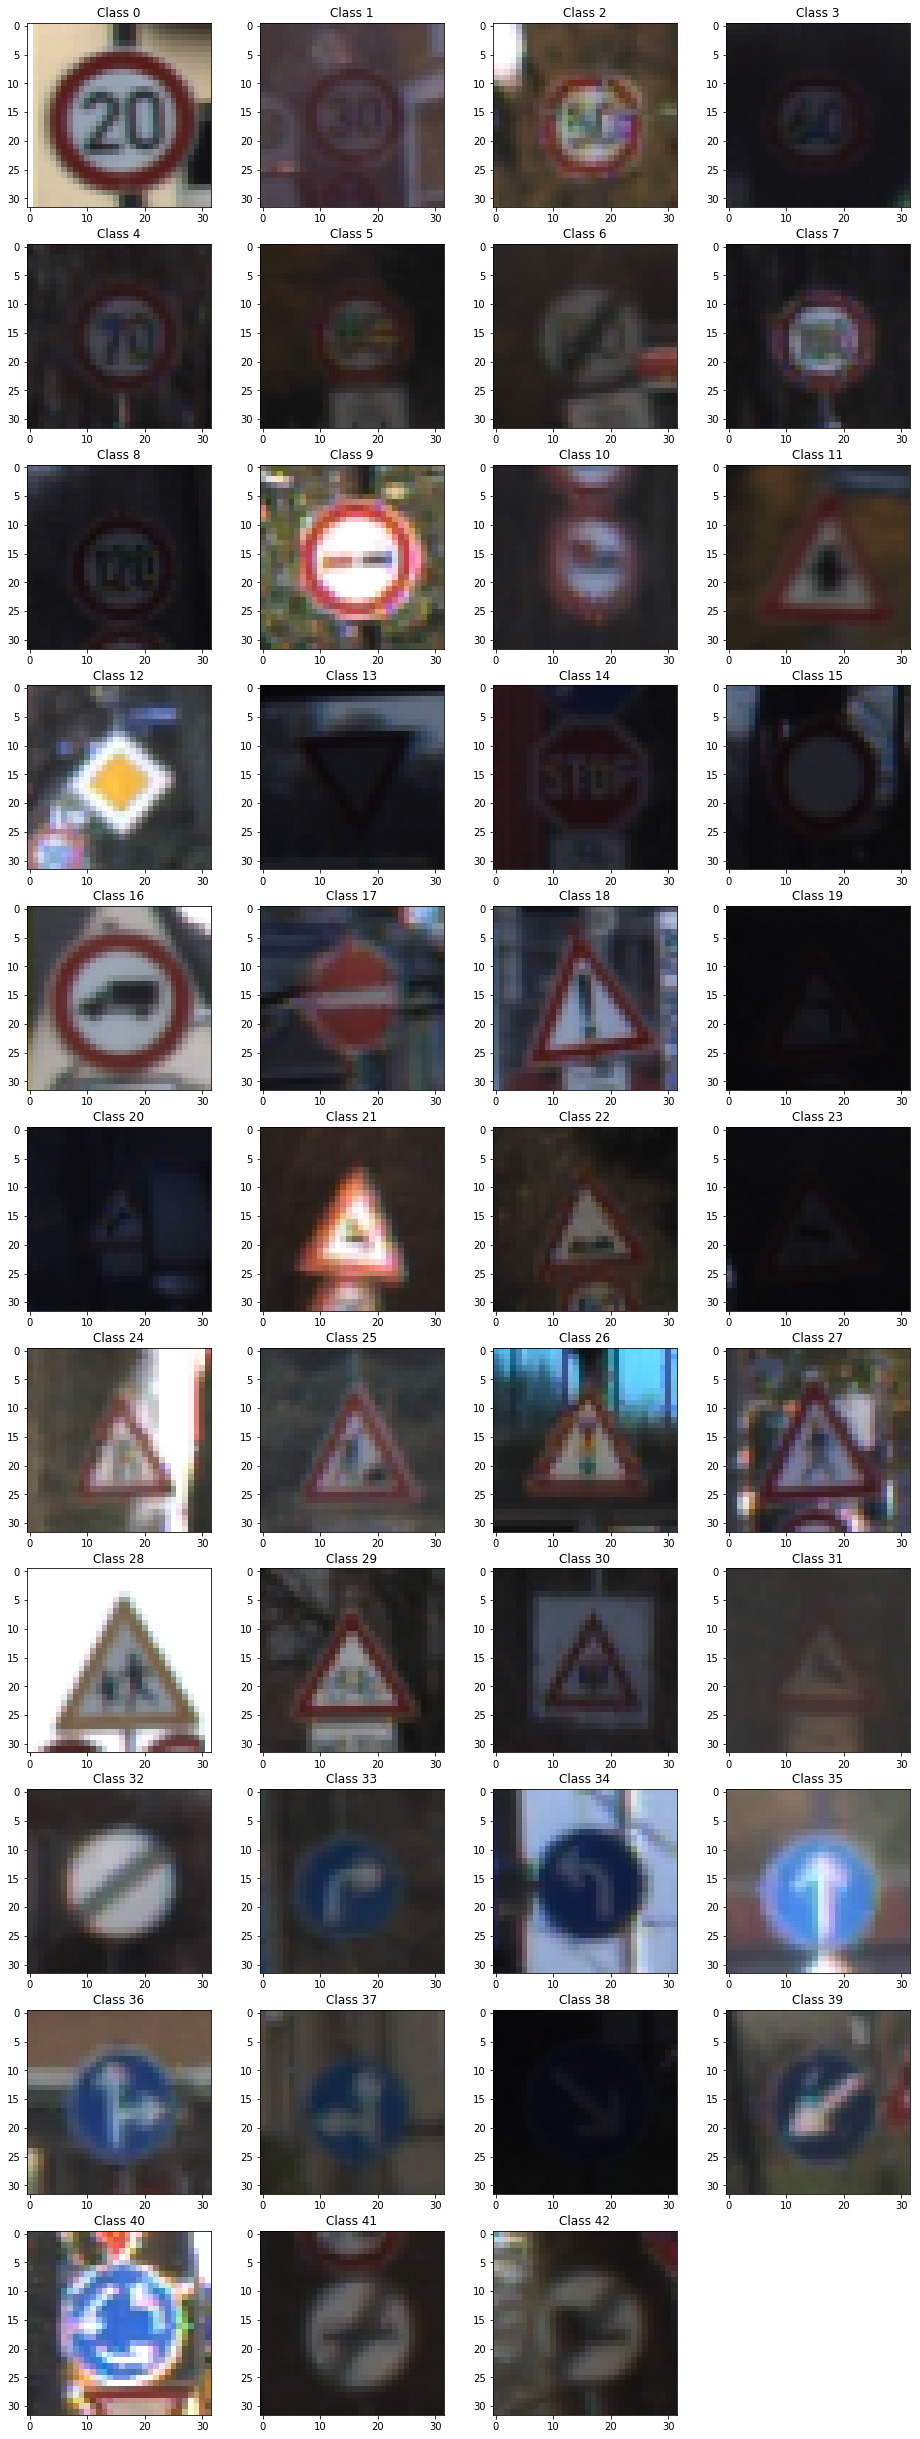

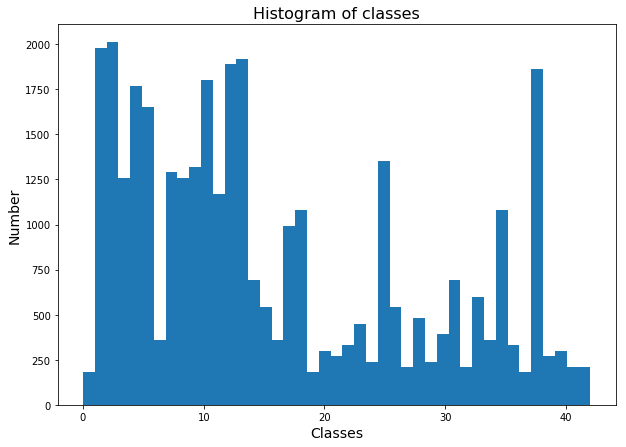

In [4]:
# plot an arbitrary image in training data for each class
fig = plt.figure(figsize=(16,44));
for i in list(range(n_classes)):
    plt.subplot(11,4,i+1);
    plt.imshow(np.squeeze(X_train[np.where(y_train == i)[0][0],:,:,:]));
    plt.title('Class ' + str(i),fontsize = 12);
#     plt.savefig('./img_writeup/raw-class-'+str(i)+'.png')

# plot the histogram of all classes in training data
fig = plt.figure(figsize = (10,7));
plt.hist(y_train,bins=43);
plt.xlabel('Classes',fontsize = 14);
plt.ylabel('Number', fontsize = 14);
plt.title('Histogram of classes', fontsize = 16);
# plt.savefig('./img_writeup/hist_raw.png')

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Preprocessing is also required for images to be input to the neural network. The basic step is normalization. Other techniques, such as converting the original RGB images to grayscale or applying histogram equalization to images, have also been tried. However, no significant improvement has been observed with grascale or histogram equalized images. Thus, simple normalization is the only preprocessing applied in this study. The performance of my final model is obtained from image augmentation and the network architecture.

Functions for preprocessing and augmentation are defined as follows. Transforms used for image augmentation were demonstrated in a following section.

In [10]:
# normalizing an image data set
def NormImg(raw_img):
    '''
    raw_img: an input 4D array of raw images (nimg, nrow, rcol, rdepth)
    '''
#     norm_img = np.ndarray(shape = raw_img.shape, dtype = np.float32)
    norm_img = (raw_img-128.0)/128.0
    return norm_img

# convert RGB images to gray scale
def RGB2GRY(raw_img):
    '''
    convert the image from RGB to grayscale
    '''
    gry_img = cv2.cvtColor(raw_img,cv2.COLOR_RGB2GRAY)
    return gry_img

# Histogram equalization on grayscale images
def HistEq(raw_img, type = 'GRAY'):
    '''
    equalize the histogram of an given image. The image can be grayscale or RGB
    '''
    if type == 'GRAY':
        eq_img = cv2.equalizeHist(raw_img)
    elif type =='RGB':
        # from IPython.core.debugger import Tracer; Tracer()()
        yuv_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2YUV)
        # equalize the histogram of the Y channel
        yuv_img[:,:,0] = cv2.equalizeHist(yuv_img[:,:,0])
        # convert the YUV image back to RGB format
        eq_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2RGB)
    return eq_img



# Image augmentation
def ImgAug(raw_img,fv = 1.0,theta = 0.0,scale=1.0,ftxy = (0.0, 0.0),fshear = np.float32(((1.0,1.0),(1.0,1.0),(1.0,1.0)))):
    '''
    change the brightness in HSV space and conver the transformed image back to RGB
    rotate the new RGB image, then translate
    theta: degree of rotation
    scale: isotropic rescaling factor to resize the image
    ftxy = (ftx, fty): ratio of shifting in x and y directions. tx = round(nx*ftx), ty = round(ny*fty)
    '''
    # change the brightness of the image
    hsv_img = np.array(cv2.cvtColor(raw_img,cv2.COLOR_RGB2HSV),dtype=np.float32)
    hsv_img[:,:,2] = hsv_img[:,:,2]*fv
    hsv_img[:,:,2][hsv_img[:,:,2]>255.0] = 255.0
    hsv_img = np.array(hsv_img,dtype=np.uint8)
    b_img = cv2.cvtColor(hsv_img,cv2.COLOR_HSV2RGB)

    # get the size of the img for transformation
    nrow,ncol,_ = b_img.shape
    # affine transformation
    # choose 3 fixed points in the image for transformation
    pt1 = np.float32([[10,10],[10,22],[22,10]])
    # calculate the shear offset with given shear range factor fshxy = (fshx,fshy)
    pt2 = np.multiply(pt1,fshear)
    # perform affine transform
    S = cv2.getAffineTransform(pt1,pt2)
    shear_img = cv2.warpAffine(b_img,S,(ncol,nrow))
    
    # rotate and rescale the image
    center = (ncol/2.0,nrow/2.0)
    M = cv2.getRotationMatrix2D(center, theta, scale)
    rotated_img = cv2.warpAffine(shear_img,M,(ncol,nrow))
    
    # translate the rotated image
    M = np.float32([[1, 0, np.float32(ncol)*ftxy[0]], [0, 1 , np.float32(nrow)*ftxy[1]]])
    shifted_img = cv2.warpAffine(rotated_img,M,(ncol,nrow))
    
    return shifted_img

# define a funciton to sample values for parameters of the image augmentation function
def AugmParams(rfbrightness = (0.1,2.5),rtheta = (-180.0, 180.0), rscale = (0.5, 1.5), 
               rftx = (-0.2, 0.2), rfty = (-0.2, 0.2), size = 1 , rfshearxy = (0.9, 1.1)):
    fbrightness = np.float32(np.random.uniform(rfbrightness[0],rfbrightness[1]))
    thetas = np.float32(np.random.uniform(rtheta[0],rtheta[1],size))
    scales = np.float32(np.random.uniform(rscale[0],rscale[1],size))
    ftxys = list(zip(np.float32(np.random.uniform(rftx[0],rftx[1],size)),np.float32(np.random.uniform(rfty[0],rfty[1],size))))
    fshearxys = np.float32(np.random.uniform(rfshearxy[0],rfshearxy[1],(size,3,2)))
    return fbrightness, thetas, scales, ftxys, fshearxys

### Data Augmentation

Data augmentation is required because the training data is asymmetric. The augmentation function below performs vertically and horizontally shifting, resizing, warping, and changes brightness of original training images with given parameter. Examples of shifting, resizing, image warping, changing of brightness are shown below.

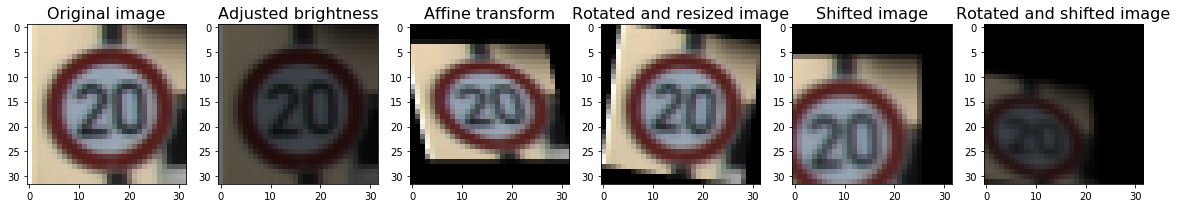

In [6]:
# Demonstrate image augmentation
raw_image = X_train[np.where(y_train == 0)[0][0],:,:,:]

fv = 0.4
theta = -8.0
scale = 0.9
ftxy = (-0.2, 0.2)
fshearxy = np.float32([[0.9,1.1],[1.1,0.9],[0.9,1.1]])

# brightness adjusted image
b_image = ImgAug(raw_image,fv = fv)

# affine transform
shear_image = ImgAug(raw_image, fshear = fshearxy)

# rotate the image for -45 (clockwise) degree around the center and rescale the image to 80% of the original size
rotated_image = ImgAug(raw_image, theta=theta, scale = scale)

# translate the image for factors 6 pixels (0.2*nx) toward -x direction, and 3 pixels (0.1*ny) toward y direction
shifted_image = ImgAug(raw_image, ftxy = ftxy)

# combined rotation and shift on the image
trans_image = ImgAug(raw_image, fv=fv,theta=theta, scale = scale, ftxy = ftxy, fshear = fshearxy)

# plot the original image vs images with different transformation
fig = plt.figure(figsize = (20,16));
# original image
plt.subplot(1,6,1)
plt.imshow(raw_image);
plt.title('Original image', fontsize = 16);
# plt.imsave('./img_writeup/aug-demo-raw.png',raw_image)
# image with adjusted brightness
plt.subplot(1,6,2)
plt.imshow(b_image);
plt.title('Adjusted brightness', fontsize = 16);
# plt.imsave('./img_writeup/aug-brightness.png',b_image)
# image with affine transformation
plt.subplot(1,6,3)
plt.imshow(shear_image);
plt.title('Affine transform', fontsize = 16);
# plt.imsave('./img_writeup/aug-shear.png',b_image)
# rotated image
plt.subplot(1,6,4)
plt.imshow(rotated_image);
plt.title('Rotated and resized image', fontsize = 16);
# plt.imsave('./img_writeup/aug-rotated-resized.png',rotated_image)
# shifted image
plt.subplot(1,6,5)
plt.imshow(shifted_image);
plt.title('Shifted image', fontsize = 16);
# plt.imsave('./img_writeup/aug-shifted.png',shifted_image)
# combination of rotation and transformation
plt.subplot(1,6,6)
plt.imshow(trans_image);
plt.title('Combined transform', fontsize = 16);
# plt.imsave('./img_writeup/aug-combined-trans.png',trans_image)

My assumption is that the training data set reflects road conditions, and the road condition determines that certain traffic signs are met more frequently than others. Hence, the proportion of categories is maintained in my augmented data. The size of a categoriy in the augmented data is 7 times more than the size of the same category in the original data. For each categary, my function randomly picks an image from the original data, on which a random combination of changing brightness, horizontal and vertical shifting, rotation and resizing, and affine transform will be applied.

In [7]:
# Augment training data for classes with record less than n_target
# the augmentation includes intensity, resize, rotate, horizontal and verical rotate
from collections import Counter
from random import randint

# count the size of each class
class_count = Counter(y_train)
# For each class, we extend the record size of each class by a factor of 5
f_class = 7
# target = 1500
# augmented images are stored at here
augm_imgs = []
augm_y = []

# loop all classes
for key,n in class_count.items():
    # if the size of this class is less than our target size, we are going to augment record in this class
    diff = n*f_class - n
#     diff = target - n
    if diff>0:
        # get all images in this class
        i_imgs = X_train[np.where(y_train == key)[0],:,:,:]
        # sample parameters for the augmentation
#         fv, thetas, scales, ftxys = AugmParams(rtheta=(0.0,0.0),rscale = (1.0,1.0),size = diff)
        fv, thetas, scales, ftxys, fshearxys = AugmParams(rtheta=(-5.0,5.0),rscale = (0.9,1.1),size = diff)
        # generate transformed images
        for i in list(range(diff)):
            # sample a random image from original images in this class
            jj = randint(0,n-1)
#             from IPython.core.debugger import Tracer; Tracer()()
            raw_img = i_imgs[jj,:,:,:].copy()
            # generate a new image using the sampled original image
            trans_img = ImgAug(raw_img,fv,thetas[i],scales[i],ftxys[i], fshearxys[i,:,:])
            # store the image in a list
            augm_imgs.append(trans_img)
        augm_y.append(np.full((diff,),key))
X_train_augm = np.stack(augm_imgs,axis=0)
y_train_augm = np.concatenate(augm_y,axis=0)
del augm_imgs,augm_y

Examples of generated images and the histogram of augmentated data were plotted below.

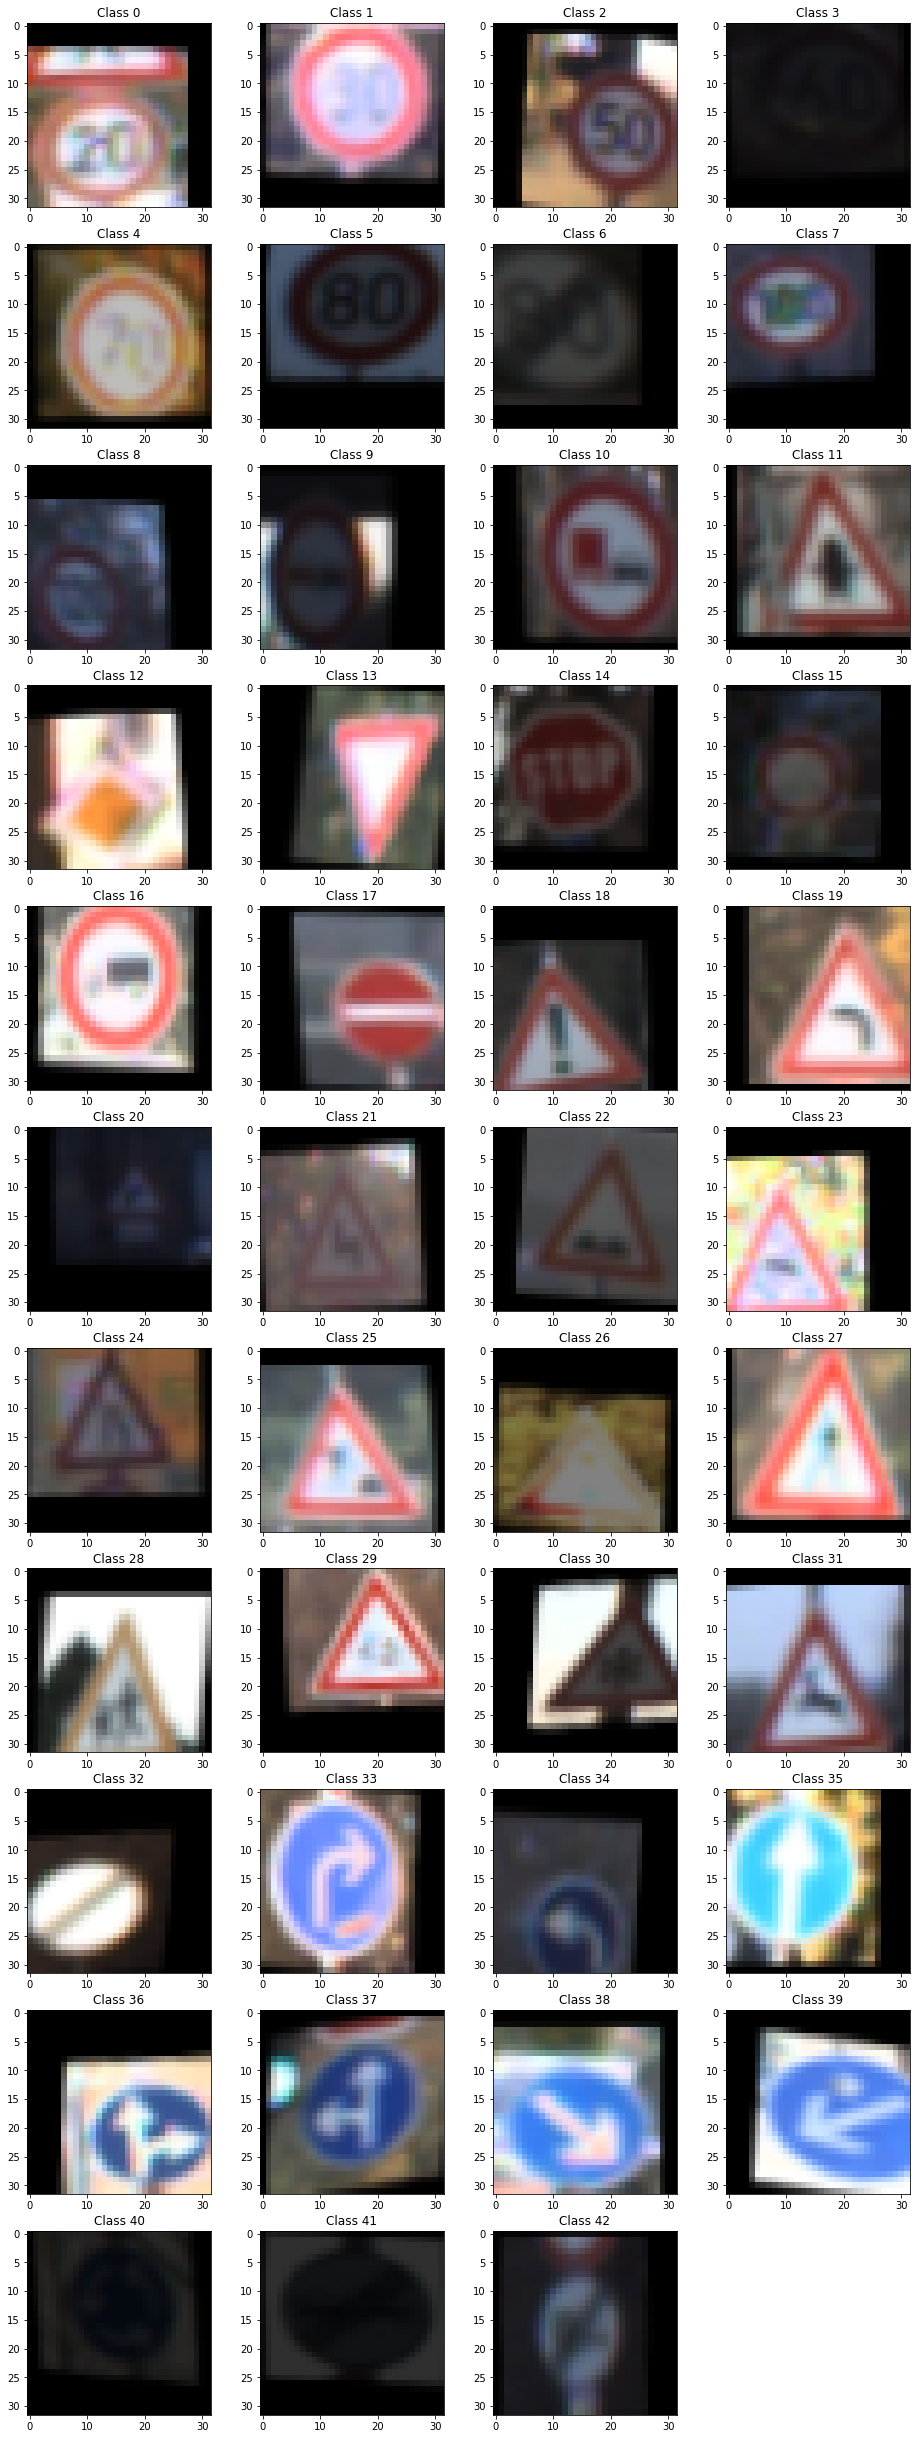

In [8]:
# plot the first image in training data for each class
fig = plt.figure(figsize=(16,44));
# for i in list(range(n_classes)):
for i in np.unique(y_train_augm):
    plt.subplot(11,4,i+1);
    img_i = np.squeeze(X_train_augm[np.where(y_train_augm == i)[0][0],:,:,:])
    plt.imshow(img_i);
    plt.title('Class ' + str(i),fontsize = 12);
    plt.imsave('./img_writeup/augm-class-'+str(i)+'.png',img_i)

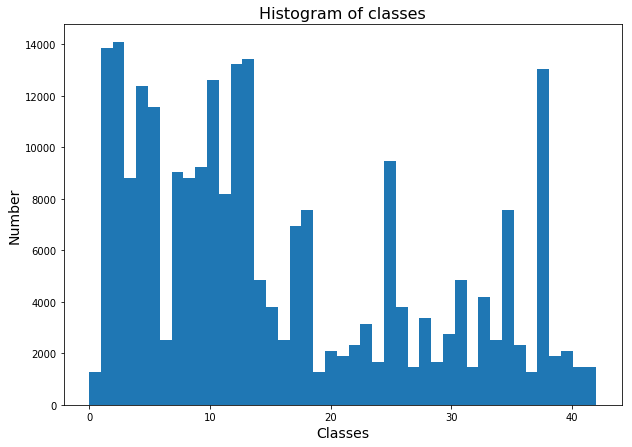

In [9]:
# # plot the first image in training data for each class
# fig = plt.figure(figsize=(16,44));
# for i in list(range(n_classes)):
#     plt.subplot(11,4,i+1);
#     plt.imshow(np.squeeze(X_train_augm[np.where(y_train_augm == i)[0][0],:,:,:]));
#     plt.title('Class ' + str(i),fontsize = 12);

# Plot the histogram of the augmented training data
X_train = np.vstack([X_train, X_train_augm])
y_train = np.concatenate([y_train,y_train_augm])
del X_train_augm, y_train_augm

# plot the histogram of all classes in training data
fig = plt.figure(figsize = (10,7));
plt.hist(y_train,bins=43);
plt.xlabel('Classes',fontsize = 14);
plt.ylabel('Number', fontsize = 14);
plt.title('Histogram of classes', fontsize = 16);
plt.savefig('./img_writeup/hist_augm.png')

Augmented images must be normalized to be input to the neural network.

In [10]:
# Normalize images

n_X_train = NormImg(X_train)

n_X_valid = NormImg(X_valid)

n_X_test = NormImg(X_test)


### Model Architecture

The layer pattern of my ConvNet model is as follows

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x3 RGB image   							| 
| Convolution 3x3     	| 1x1 stride, same padding, outputs 32x32x16 	|
| RELU					|												|
| DROPOUT               |                                               |
| Convolution 3x3     	| 1x1 stride, same padding, outputs 32x32x32 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 16x16x32 				|
| DROPOUT               |                                               |
| Convolution 3x3     	| 1x1 stride, same padding, outputs 16x16x64 	|
| RELU					|												|
| DROPOUT               |
| Convolution 3x3     	| 1x1 stride, same padding, outputs 16x16x64 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 8x8x64 				    |
| DROPOUT               |                                               |
| Convolution 3x3     	| 1x1 stride, same padding, outputs 8x8x128 	|
| RELU					|												|
| DROPOUT               |                                               |
| Convolution 3x3     	| 1x1 stride, same padding, outputs 8x8x128 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 4x4x64    				|
| DROPOUT               |                                               |
| Fully connected		| 2048x2048    									|
| DROPOUT               |                                               |
| Fully connected		| 2048x1024    									|
| DROPOUT               |                                               |
| Fully connected		| 1024x10     									|
      
The model includes six convolutional layers and three fully connected layers. Connected convolutional layers enable a wide view on the inputs for the model. Every convolutional layer and fully connected layer is followed by a dropout layer, which has effectively reduced overfitting. A pooling layer is used after every two convolutional layers, hence the size of feature maps are not shrinking too fast. In 70 epoches, the model achieves 97% validation accuracy. The accuracy on the pickled test data is 98%.

In [11]:
# my ConvNet best accuracy 96.8%, epoch=70, learning rate 2e-4
from tensorflow.contrib.layers import flatten

def ConvNet(x,n_classes, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 1
    
    img_depth = x.get_shape().as_list()[3]
#     from IPython.core.debugger import Tracer; Tracer()()
    # Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16
    conv1_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, img_depth, 16))/np.sqrt(3.0*3.0*np.float32(img_depth)*16.0))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.layers.dropout(conv1,keep_prob,name='conv1')    

    # Layer 2: Convolutional. Output = 32x32x32.
    conv2_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, 16, 32))/np.sqrt(3.0*3.0*16.0*32.0))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 32x32x32. Output = 16x16x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.layers.dropout(conv2,keep_prob,name='conv2')      

    # Layer 3: Convolutional. Output = 16x16x64
    conv3_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, 32, 64))/np.sqrt(3.0*3.0*32.0*64.0))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.layers.dropout(conv3,keep_prob,name='conv3')    

    # Layer 4: Convolutional. Output = 16x16x64
    conv4_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, 64, 64))/np.sqrt(3.0*3.0*64.0*64.0))
    conv4_b = tf.Variable(tf.zeros(64))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b
    
    # Activation.
    conv4 = tf.nn.relu(conv4)

    # Pooling. Input = 16x16x64. Output = 8x8x64.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4 = tf.layers.dropout(conv4,keep_prob,name='conv4')    

    # Layer 5: Convolutional. Output = 8x8x128
    conv5_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, 64, 128))/np.sqrt(3.0*3.0*64.0*128.0))
    conv5_b = tf.Variable(tf.zeros(128))
    conv5   = tf.nn.conv2d(conv4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    
    # Activation.
    conv5 = tf.nn.relu(conv5)
    conv5 = tf.layers.dropout(conv5,keep_prob,name='conv5')    

    # Layer 6: Convolutional. Output = 8x8x128
    conv6_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(3, 3, 128, 128))/np.sqrt(3.0*3.0*128.0*128.0))
    conv6_b = tf.Variable(tf.zeros(128))
    conv6   = tf.nn.conv2d(conv5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b
    
    # Activation.
    conv6 = tf.nn.relu(conv6)

    # Pooling. Input = 8x8x128. Output = 4x4x128.
    conv6 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv6 = tf.layers.dropout(conv6,keep_prob,name='conv6')    
    
    # Flatten. Input = 4x4x128. Output = 2048
    fc0   = flatten(conv6)
    
    # Layer 7: Fully Connected. Input = 2048. Output = 2048.
    fc1_W = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(2048, 2048))/np.sqrt(2048.0*2048.0))
    fc1_b = tf.Variable(tf.zeros(2048))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.layers.dropout(fc1,keep_prob,name='fc1')

    # Layer 8: Fully Connected. Input = 2048. Output = 1024.
    fc2_W  = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(2048, 1024))/np.sqrt(2048.0*1024.0))
    fc2_b  = tf.Variable(tf.zeros(1024))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.layers.dropout(fc2,keep_prob,name='fc2')

    # SOLUTION: Layer 9: Fully Connected. Input = 1024. Output = 10.
    fc3_W  = tf.Variable(2.0**0.5*tf.truncated_normal(shape=(1024, n_classes))/np.sqrt(1024.0*n_classes))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.add(tf.matmul(fc2, fc3_W), fc3_b, name = 'logits')
    
    return logits

### Train, Validate and Test the Model

I ended up with following hyperparameters for this model.

learning_rate = 2e-4

batch_size = 128

epoch = 70

In [13]:
# input nodes for our neural network
x = tf.placeholder(tf.float32,(None,32,32,n_X_train.shape[3]), name = 'x')
y = tf.placeholder(tf.int32, (None), name = 'y')
k_prob = tf.placeholder(tf.float32, (), name = 'k_prob')
ohe_y = tf.one_hot(y,n_classes)

#### Training Pipeline

In [14]:
lrate = 2e-4
keep_prob = 0.5

EPOCHS = 70
BATCH_SIZE = 128

logits = ConvNet(x,n_classes,k_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=ohe_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lrate)
# # update
# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(ohe_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in list(range(0, num_examples, BATCH_SIZE)):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, k_prob:keep_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model

In [17]:
tr_acc = []
v_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(n_X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        n_X_train, y_train = shuffle(n_X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = n_X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, k_prob: keep_prob})
            
        training_accuracy = evaluate(n_X_train,y_train)
        validation_accuracy = evaluate(n_X_valid, y_valid)
        test_accuracy = evaluate(n_X_test, y_test)
        
        tr_acc.append(training_accuracy)
        v_acc.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}, Validation Accuracy = {:.3f}"
              .format(training_accuracy,validation_accuracy))
        print()
#         # Save the model every 100 iterations
#         if (i % 33 == 0) & (i > 0):
#             saver.save(sess, "./model", global_step=i)
#             print("Model saved at EPOCH = " + str(i+1))
    saver.save(sess, './ConvNet2')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.440, Validation Accuracy = 0.314

EPOCH 2 ...
Training Accuracy = 0.644, Validation Accuracy = 0.489

EPOCH 3 ...
Training Accuracy = 0.778, Validation Accuracy = 0.635

EPOCH 4 ...
Training Accuracy = 0.856, Validation Accuracy = 0.749

EPOCH 5 ...
Training Accuracy = 0.925, Validation Accuracy = 0.825

EPOCH 6 ...
Training Accuracy = 0.935, Validation Accuracy = 0.837

EPOCH 7 ...
Training Accuracy = 0.952, Validation Accuracy = 0.858

EPOCH 8 ...
Training Accuracy = 0.980, Validation Accuracy = 0.897

EPOCH 9 ...
Training Accuracy = 0.978, Validation Accuracy = 0.902

EPOCH 10 ...
Training Accuracy = 0.983, Validation Accuracy = 0.910

EPOCH 11 ...
Training Accuracy = 0.989, Validation Accuracy = 0.926

EPOCH 12 ...
Training Accuracy = 0.965, Validation Accuracy = 0.906

EPOCH 13 ...
Training Accuracy = 0.992, Validation Accuracy = 0.920

EPOCH 14 ...
Training Accuracy = 0.961, Validation Accuracy = 0.899

EPOCH 15 ...
Training Accuracy

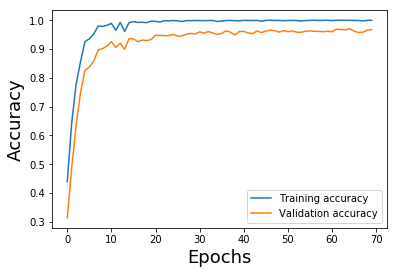

In [20]:
# Plot training, validation, and test accuracy
tr_acc_plt, = plt.plot(range(EPOCHS),tr_acc);        
v_acc_plt, = plt.plot(range(EPOCHS),v_acc);
plt.xlabel('Epochs',fontsize = 18);
plt.ylabel('Accuracy',fontsize = 18);
plt.legend([tr_acc_plt,v_acc_plt],['Training accuracy','Validation accuracy']);
plt.show();
plt.savefig('./img_writeup/conv_training.png');

The test accuracy is 98.3% as shown below.

In [26]:
# check test accuracy
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./ConvNet2.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    test_accuracy = evaluate(n_X_test, y_test)
    print('The test accuracy is: {:05.2f}%'.format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ./ConvNet2
The test accuracy is: 98.28%


## Step 3: Test a Model on New Images

In order to test my ConvNet model, I have downloaded 6 from the internet as shown below.

### Load and Output the Images

In [5]:
from os import walk
import pandas as pd

def LoadTests():
    '''
    load and resize test images into a nimg x 32 x 32 x 3  array and .cvs of sign names
    return 1. image array; 2. a list of true classes of test images; 3. sign names vs classes as a dict
    '''    
    # import test images and class names
    items = list(walk('./img_test/'))
    fList = [item[0]+'/'+item[2][0] for item in items[1:]]
    trClass = np.int32(items[0][1])
    
    # load test images
    imgList = []    
    for file in fList:
        img_tmp = plt.imread(file)
        imgList.append(cv2.resize(img_tmp,(32,32),interpolation=cv2.INTER_AREA))
    RGBImg = np.stack(imgList)
    
    # load sign names
    key_values = np.genfromtxt('./signnames.csv', delimiter = ",", skip_header = 1, dtype = None)
    signName = { key_value[0]:key_value[1].decode('UTF-8') for key_value in key_values}
        
    return RGBImg, trClass, signName

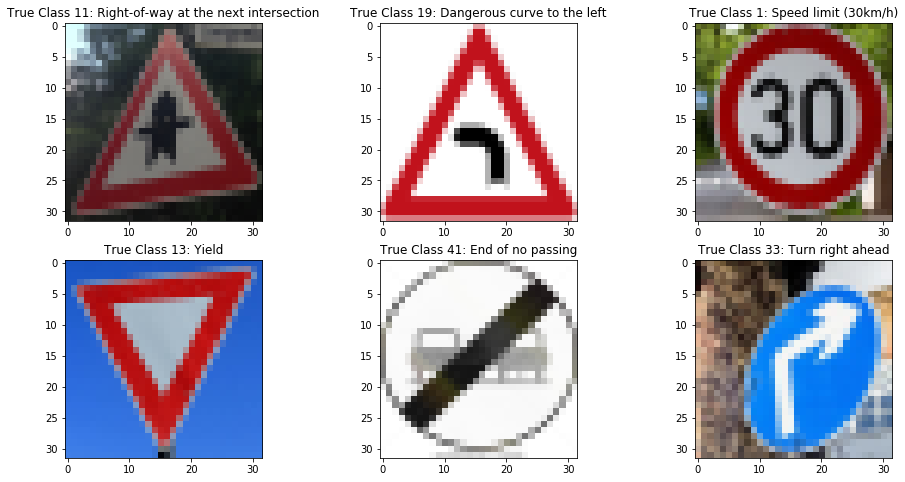

In [6]:
### Load the images and plot them here.
t_imgs, trClass, signName = LoadTests()

# plot
fig = plt.figure(figsize=(16,8));
for i in list(range(len(t_imgs))):
    plt.subplot(2,3,i+1);
    plt.imshow(np.squeeze(t_imgs[i,:,:,:]));
    plt.title('True Class ' + str(trClass[i]) + ': ' + str(signName[np.int(trClass[i])]),fontsize = 12);

### Predict the Sign Type for Each Image

Normalize test images, restore the saved model, and make prediction for classes of test images.

In [11]:
# normalized test images
n_t_imgs = NormImg(t_imgs)

In [12]:
# Restore the saved model and make prediction for classes of images
with tf.Session() as sess:
    sess = tf.Session()
    saver = tf.train.import_meta_graph('./ConvNet2.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    print('Model restored')

    x = sess.graph.get_tensor_by_name('x:0')
    k_prob = sess.graph.get_tensor_by_name('k_prob:0')
    logits = sess.graph.get_tensor_by_name('logits:0')
    # prediction = sess.run( tf.argmax(logits,1),feed_dict={ x:n_t_imgs, k_prob:1.0})
    prediction = sess.run( tf.argmax(tf.nn.softmax(logits),1),feed_dict={ x:n_t_imgs, k_prob:1.0})
#     accuracy = sum(np.equal(prediction,trClass))/len(prediction)
#     print('The accuracy is {}'.format(accuracy))

INFO:tensorflow:Restoring parameters from ./ConvNet2
Model restored


### Analyze Performance

66.67% accuracy is achieved on all 6 test images. 

All of the six images are relatively easy to be recognized, since they are in overall clearly taken. Although the first (true class id 11) and sixth (true class id 33) are not in the front view, but this have been incoorporated in the augmented data by applying affine transform. The prediction on the second (true class id 19) and fifth (true class id 41) are incorrect. This may be explained by the asymmetry of the augmented data. The proportion of Class 19 and Class 41 are low, and they are predicted to be classes of higher proportions, e.g. Class 29 and 1. Hence, it may be inapproprate to keep the proportion of classes in the augmented data. My improvement will be training the model with symmetric augmented data.

The accuracy is 66.67%


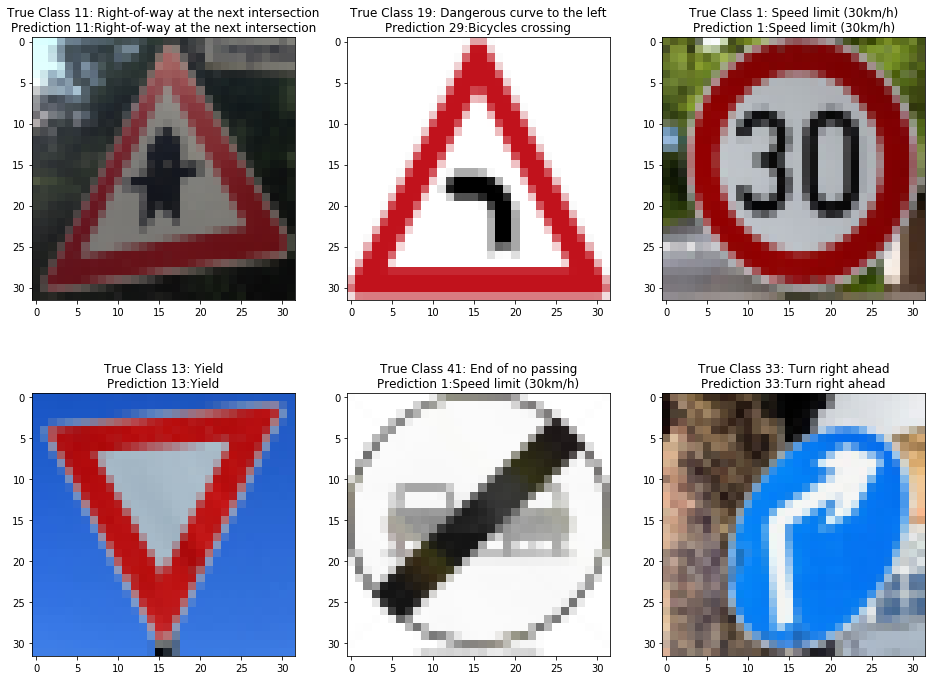

In [13]:
# Evaluate accuracy of the prediction
accuracy = sum(np.equal(prediction,trClass))/len(prediction)*100
print('The accuracy is {:05.2f}%'.format(accuracy))
# plot results vs true labels
fig = plt.figure(figsize=(16,12));
for i in list(range(len(t_imgs))):
    plt.subplot(2,3,i+1);
    plt.imshow(np.squeeze(t_imgs[i,:,:,:]));
    plt.title('True Class ' + str(trClass[i]) + ': ' + str(signName[np.int(trClass[i])]) + '\n' 
              + 'Prediction ' + str(prediction[i]) + ':' + str(signName[np.int(prediction[i])]),fontsize = 12);
#     plt.savefig('./img_writeup/test-img-trClass-' + str(trClass[i]) + 'Prediction ' + str(prediction[i]) + '.png')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

The top five softmax probabilities for each test image by my model are listed below. It seems my model is very confident on its prediction. For correctly predicted images, the model is 100% sure on the best choice. Although probabilities of the best predictions are not 100% for incorrect predictions, the probabilities are greater than 99%. Referred to images of each class shown above, the top 5 predictions for incorrect predictions are very similar to the truth, e.g. red triangular frames are observed for all top 5 preditions for Image 3. Differences between those predictions exist in the center of the red triangle frame. In order to recognize these small scale differences, multiscale structures may be considered to improve my model.

In [14]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    sess = tf.Session()
    saver = tf.train.import_meta_graph('./ConvNet2.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    prediction = sess.run( tf.nn.top_k(tf.nn.softmax(logits),5),feed_dict={ x:n_t_imgs, k_prob:1.0})

INFO:tensorflow:Restoring parameters from ./ConvNet2


In [59]:
# print top 5 softmapx probabilities
top_n_ind = prediction.indices
top_n_p = prediction.values

for i in list(range(len(trClass))):
    print('Test Image '+str(i)+'\nTrue id ' + str(trClass[i]) + '     ' + str(signName[np.int(trClass[i])])) 
    print('\nTop 5 preditions:softmax probabilities:')
    for j in list(range(5)):
        print('id {}    {}   :   {:05.2f}%'.format(top_n_ind[i][j], signName[top_n_ind[i][j]], top_n_p[i][j]*100))
    print('\n')

Test Image 0
True id 11     Right-of-way at the next intersection

Top 5 preditions:softmax probabilities:
id 11    Right-of-way at the next intersection   :   100.00%
id 27    Pedestrians   :   00.00%
id 18    General caution   :   00.00%
id 30    Beware of ice/snow   :   00.00%
id 35    Ahead only   :   00.00%


Test Image 1
True id 19     Dangerous curve to the left

Top 5 preditions:softmax probabilities:
id 29    Bicycles crossing   :   99.92%
id 24    Road narrows on the right   :   00.08%
id 19    Dangerous curve to the left   :   00.00%
id 25    Road work   :   00.00%
id 27    Pedestrians   :   00.00%


Test Image 2
True id 1     Speed limit (30km/h)

Top 5 preditions:softmax probabilities:
id 1    Speed limit (30km/h)   :   100.00%
id 0    Speed limit (20km/h)   :   00.00%
id 2    Speed limit (50km/h)   :   00.00%
id 4    Speed limit (70km/h)   :   00.00%
id 5    Speed limit (80km/h)   :   00.00%


Test Image 3
True id 13     Yield

Top 5 preditions:softmax probabilities:
id 1

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

Eight arbitrary feature maps from the outputs of each convolutional layers are shown below. The observation is that the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

In [41]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = np.amin([activation.shape[3],plt_num])
#     featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15));

    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

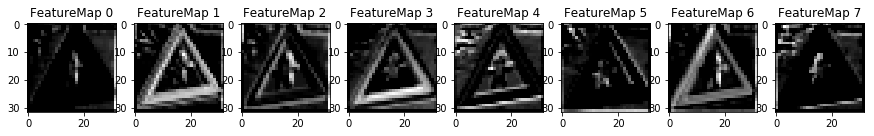

In [42]:
conv1 = sess.graph.get_tensor_by_name('conv1/Identity:0')
outputFeatureMap(n_t_imgs,conv1, plt_num=8)

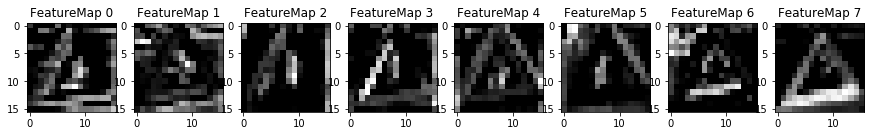

In [43]:
conv2 = sess.graph.get_tensor_by_name('conv2/Identity:0')
outputFeatureMap(n_t_imgs[0:1,:,:,:],conv2, plt_num=8)

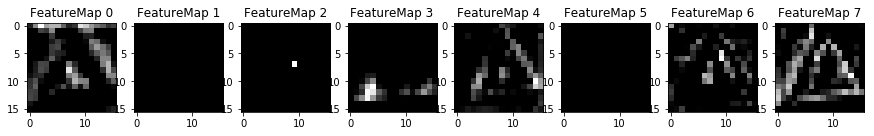

In [44]:
conv3 = sess.graph.get_tensor_by_name('conv3/Identity:0')
outputFeatureMap(n_t_imgs,conv3, plt_num=8)

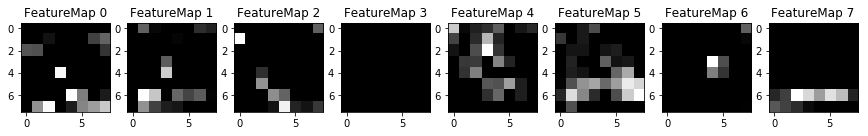

In [45]:
conv4 = sess.graph.get_tensor_by_name('conv4/Identity:0')
outputFeatureMap(n_t_imgs,conv4, plt_num=8)

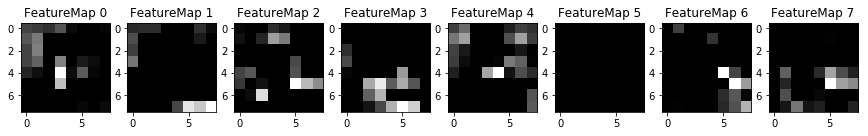

In [46]:
conv5 = sess.graph.get_tensor_by_name('conv5/Identity:0')
outputFeatureMap(n_t_imgs,conv5, plt_num=8)

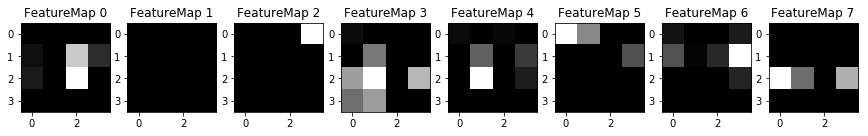

In [47]:
conv6 = sess.graph.get_tensor_by_name('conv6/Identity:0')
outputFeatureMap(n_t_imgs,conv6, plt_num=8)